<a href="https://colab.research.google.com/github/sapperka/AZSII/blob/main/%D0%90%D0%97%D0%A1%D0%98%D0%98_%D0%91%D0%91%D0%9C%D0%9E_02_23_%D0%A0%D1%8B%D0%B1%D0%B0%D0%BA%D0%BE%D0%B2_%D0%9B%D0%A03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Лабораторная работа 3**

По предмету: **Анализ защищенности систем искусственного интеллекта**

Выполнил студент **2 курса** группы **ББМО-02-23**

**Рыбаков Владислав Андреевич**

##Импорт библиотек

In [ ]:
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import tensorflow as tf
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16 as Model

##Загрузим случайные изображения:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls content/drive

ls: cannot access 'content/drive': No such file or directory


In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

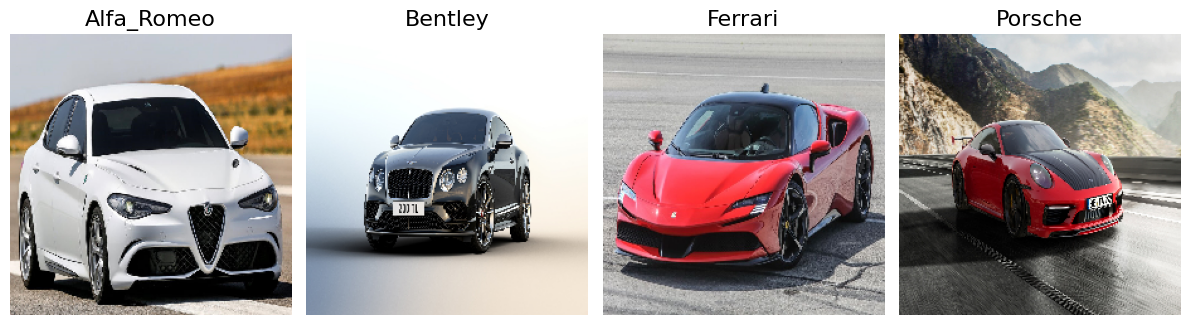

In [ ]:
# Загружаем предобученную модель VGG16 с весами ImageNet:
model = Model(weights='imagenet', include_top=True)
# Создадим списки изображений и путей к ним для загрузки:

# Пути к изображениям
img_paths = [
    '/content/drive/MyDrive/AZSII/Alfa_Romeo.jpg',
    '/content/drive/MyDrive/AZSII/Bentley.jpg',
    '/content/drive/MyDrive/AZSII/Ferrari.jpg',
    '/content/drive/MyDrive/AZSII/Porsche.jpeg'
]

# Заголовки для изображений
image_titles = ['Alfa_Romeo', 'Bentley', 'Ferrari', 'Porsche']

# Загрузка изображений
images = [load_img(path, target_size=(224, 224)) for path in img_paths]

# Преобразование изображений в массив NumPy
processed_images = np.array([img_to_array(img) for img in images])

# Подготовка данных для VGG16
X = preprocess_input(processed_images)

# Визуализация изображений
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

##Когда функция активации softmax применяется к последнему слою модели, это может препятствовать созданию изображений внимания, поэтому следует заменить эту функцию на функцию линейной активации. Хотя здесь мы создаем и используем экземпляр ReplaceToLinear, мы также можем использовать функцию модификатора модели, определенную нами.

In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

##Cоздание экземпляра Score. Определяем score function, которая возвращает целевые баллы.

In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore

score = CategoricalScore([285, 277, 330, 675])

# Вместо использования объекта CategoricalScore
# определим функцию с нуля следующим образом:
def score_function(output):
    # Переменная `output` ссылается на выходы модели,
    # таким образом, что размерность `output` равна `(3, 1000)` где, (номер примера, номер класса)
    return (output[0][285], output[1][277], output[2][330], output[3][675])

##Saliency генерирует карту значимости, на которой отображаются области входного изображения, которые имеют наибольшее влияние на выходное значение.

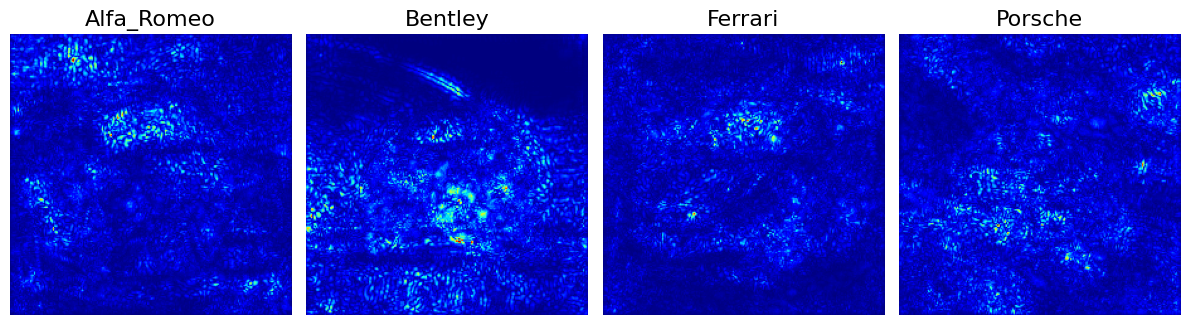

CPU times: user 1.28 s, sys: 861 ms, total: 2.14 s
Wall time: 2.01 s


In [ ]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency

# Создаем объект внимания
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Генерируем карту внимания
saliency_map = saliency(score, X)

# Выводим
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

##Карта значимости Vanilla слишком шумная, поэтому следует удалить шум на карте значимости с помощью SmoothGrad, который уменьшает шум на карте значимости путем добавления шума к входному изображению.

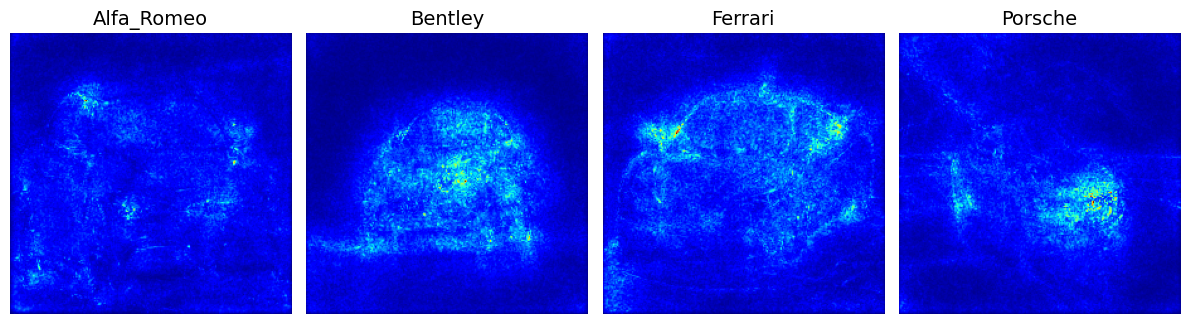

CPU times: user 2.37 s, sys: 228 ms, total: 2.59 s
Wall time: 3.56 s


In [ ]:
%%time

# Генерируем карту внимания со сглаживанием, которое уменьшает шум за счет добавления шума
saliency_map = saliency(score,
                        X,
                        smooth_samples=20, # Количество итераций расчета градиентов
                        smooth_noise=0.20) # уровень распространения шума

# Выводим
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('smoothgrad.png')
plt.show()

##Визуализация тепловой карты - *GradCam*

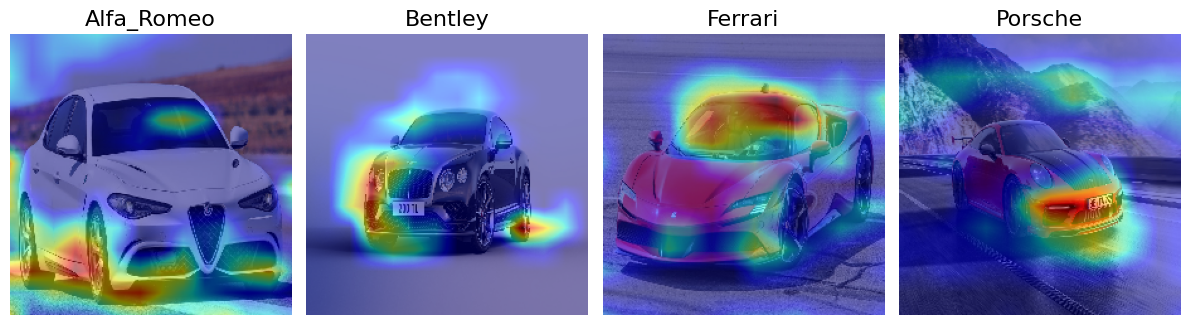

CPU times: user 1.54 s, sys: 906 ms, total: 2.45 s
Wall time: 2.46 s


In [ ]:
%%time

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Создаём объект визуализации Gradcam
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Генерируем тепловую карту с помощью GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)

# Выводим
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :4] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

Как можно заметить, тепловые пятна не полностью покрывают цель на изображениях. В следующем шаге мы устраним этот недостаток. На текущем этапе создания карты появился новый параметр. Предпоследний слой здесь представляет собой сверточный слой, расположенный ближе всего к плотным слоям. Выходные данные этого слоя используются GradCam для получения градиентов.

##GradCam++ — улучшенная версия GradCam, позволяющий обеспечить лучшее визуальное объяснение прогнозов модели CNN.

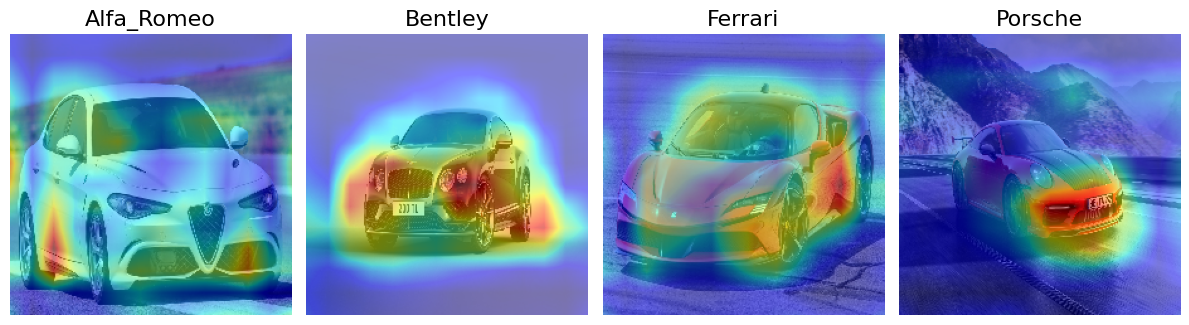

CPU times: user 1.85 s, sys: 937 ms, total: 2.79 s
Wall time: 2.94 s


In [ ]:
%%time

from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# Создаем объект GradCAM++
gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)
# Генерируем тепловую карту с помощью GradCAM++
cam = gradcam(score,
              X,
              penultimate_layer=-1)
# Визуализируем
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :4] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('gradcam_plus_plus.png')
plt.show()